### **Отчёт по лабораторной работе № 2**



**по дисциплине «Технологии обеспечения информационной безопасностью»**

**Тема: «Анализ логов»**

Номер варианта = 11 mod 16 + 1 = 12
Proxifier

Выполнил
Студент 1 курса
Группы ББМО-01-23
Белов Владимир Станиславович


1) Клонирование репозитория с логами для их  анализа

In [561]:
import os.path

if not os.path.isdir("./loghub/"):
    !git clone https://github.com/logpai/loghub

### Задание регулярного выражения для парсинга логов

Пример лога из файла Proxifier_2k.log, который необходимо распарсить:

[10.30 16:49:07] chrome.exe - proxy.cse.cuhk.edu.hk:5070 open through proxy proxy.cse.cuhk.edu.hk:5070 HTTPS

Поля лога:

- 10.30 - Data, Группа для извлечения даты в формате `MM:DD`.
- 16:49:07 - 	Time, в формате `HH:MM:SS`
- chrome.exe - Program
- proxy.cse.cuhk.edu.hk:5070 open through proxy proxy.cse.cuhk.edu.hk:5070 HTTPS - content, содержание записи, все символы до конца строки


In [618]:
import re

line="[10.30 16:49:07] chrome.exe - proxy.cse.cuhk.edu.hk:5070 open through proxy proxy.cse.cuhk.edu.hk:5070 HTTPS"

regex_pattern=r'\[(\d{2}.\d{2})\s(\d{2}:\d{2}:\d{2})\]\s(\w+.\w+)(.*)'

### **Создание базы данных**
В среде выполнения создаётся каталог ./db, где будет храниться файл базы данных SQLite

In [614]:
if not os.path.isdir("./db/"):
  os.makedirs("./db/")

In [619]:
import sqlite3

# путь к файлу с БД
db_path = './db/log-analysis.db'

# подключение к БД
connection = sqlite3.connect(db_path)
# создание курсора
cursor = connection.cursor()

# очистка БД, если таблица уже создана
cursor.execute("DROP TABLE IF EXISTS logs")
# создание таблицы
cursor.execute("CREATE TABLE logs (id INTEGER PRIMARY KEY AUTOINCREMENT, Data int, Time int, Program text, Content)")

# сохранение изменений
connection.commit()
# закрытие курсора
cursor.close()
# закрытие подключения к БД
connection.close()

### Парсинг лога и занисение данных в БД


In [620]:
from pickle import NONE
# подключение к БД и создание курсора
connection = sqlite3.connect(db_path)
cursor = connection.cursor()

# очистка таблицы во избежание дублирования данных
cursor.execute("DELETE FROM logs")

# парсинг файла с логом
with open('./loghub/Proxifier/Proxifier_2k.log', 'r', encoding='utf-8') as file:
    for line in file:
        log = re.match(regex_pattern, line)
        if log:
            data = log.group(1)
            time = log.group (2)
            program = log.group(3)
            content = log.group(4)
            values = (data,  time, program, content) # создание объекта для подстановки в SQL-запрос
            sql = "INSERT INTO logs (Data, Time, Program, Content) VALUES  (?, ?, ?, ?)"
            cursor.execute(sql, values) # запись данных в БД

connection.commit()
cursor.close()
connection.close()

### Чтение данных из БД

In [621]:
import pandas as pd

# подключение к БД и создание курсора
connection = sqlite3.connect(db_path)
cursor = connection.cursor()

# выборка всех записей из таблицы
cursor.execute("SELECT * FROM logs")
rows = cursor.fetchall()

cursor.close()
connection.close()

# запись данных в объект DataFrame
log_df = pd.DataFrame(rows, columns=("ID", "Data", "Time", "Program", "Content"))
log_df

,ID,Data,Time,Program,Content
0,1,10.30,16:49:06,chrome.exe,- proxy.cse.cuhk.edu.hk:5070 open through pro...
1,2,10.30,16:49:06,chrome.exe,- proxy.cse.cuhk.edu.hk:5070 open through pro...
2,3,10.30,16:49:06,chrome.exe,- proxy.cse.cuhk.edu.hk:5070 open through pro...
3,4,10.30,16:49:07,chrome.exe,"- proxy.cse.cuhk.edu.hk:5070 close, 0 bytes s..."
4,5,10.30,16:49:07,chrome.exe,- proxy.cse.cuhk.edu.hk:5070 open through pro...
...,...,...,...,...,...
1995,1996,7.27,10:23:30,chrome.exe,"*64 - cpro.baidustatic.com:443 close, 334 byt..."
1996,1997,7.27,10:23:30,chrome.exe,*64 - q1.cnzz.com:80 open through proxy proxy...
1997,1998,7.27,10:23:42,chrome.exe,"*64 - t12.baidu.com:80 close, 0 bytes sent, 0..."
1998,1999,7.27,10:23:42,chrome.exe,"*64 - mhfm9.us.cdndm5.com:80 close, 0 bytes s..."


### Статистический анализ и визуализация

1) Распределение отчётов по дате получения


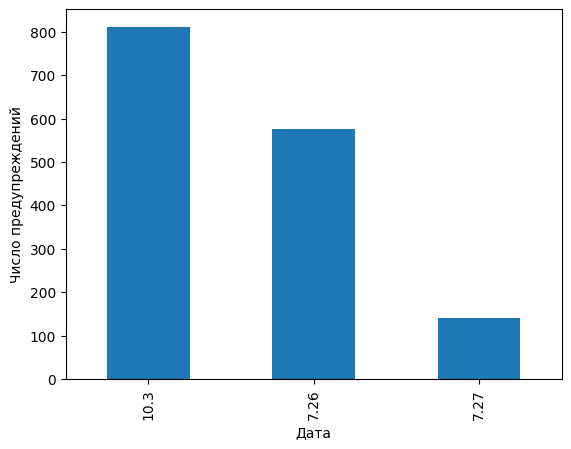

In [626]:
alerts_distrib = log_df[log_df['Program']=='chrome.exe'].copy()

alerts_distrib = alerts_distrib['Data'].value_counts()

alerts_distrib.plot(kind='bar')

plt.xlabel('Дата')
plt.ylabel('Число предупреждений')
plt.show()

2) Распределение отчётов по программам

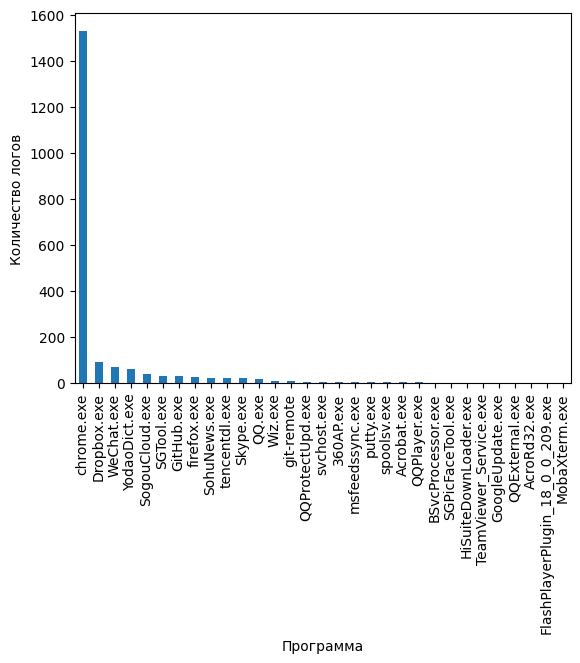

In [591]:
import matplotlib.pyplot as plt

components_distrib = log_df['Program'].value_counts()

components_distrib.plot(kind='bar')

plt.xlabel('Программа')
plt.ylabel('Количество логов')
plt.show()